### Convolutional Neural Networks:

This notebook will cover fitting a CNN, and in particular will cover the specifics of using convolutional filters. 

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#### Convolutional Filters: 

Brief demonstration of how convolutional filters work (not in a model):

- PyTorch uses a "channel first" notation, which means typically when we print shapes, the first argument will be the number of channels. 
- In this case we've instantiated a 2D-Convolutional Layer, which maps a 3-channel Tensor to a 2-channel tensor using a 2x2 Kernel matrix on each layer. 

In [21]:
conv2d = nn.Conv2d(3, 2, 2)
print(conv2d.weight.shape)

torch.Size([2, 3, 2, 2])


In [22]:
a = torch.ones(1,3,3,3)

##### How is the convolutional filter applied?

- Based on the number of output channels, each output channel has an associated 3 channel kernel tensor. 
- Each 3-channel kernel tensor will be a 3x2x2 matrix. Which is placed "over" the input, then we map the input to a value in the output channel by doing an element wise product.
- Thus a 1x3x3x3 tensor will be mapped to 1x2x2x2 tensor using this convolutional filter. 

In [24]:
b = conv2d(a)
print(b.shape)

torch.Size([1, 2, 2, 2])


### CIFAR 10 - Convolutional Neural Network:

The CIFAR-10 Dataset is a dataset containing images, classified as one from the following:

- Airplane										
- Automobile										
- Bird										
- Cat										
- Deer										
- Dog										
- Frog										
- Horse										
- Ship										
- Truck

CNNs are suitable here as we're using image data.

In [58]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Data Exploration:

To build some more familiarity with PyTorch, I'll be exploring the datasets and objects. 

In [28]:
train_data = torchvision.datasets.CIFAR10(root='./', download=True, 
                                          train=True)

170500096it [03:30, 1512614.20it/s]                               

In [32]:
print(type(train_data))
print(type(train_data.data))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'numpy.ndarray'>


In [37]:
numpy_data = train_data.data
print(numpy_data.shape)

(50000, 32, 32, 3)


From this we can conclude:

- Training data is 50,000 datapoints. 
- Images are stored as 32x32x3 arrays. (32x32 Pixel Pictures)
- 3 channels, probably an RGB breakdown. 

In [39]:
datapoints = numpy_data[:6,:, :, :]
print(datapoints.shape)

(6, 32, 32, 3)


Exploring our images:

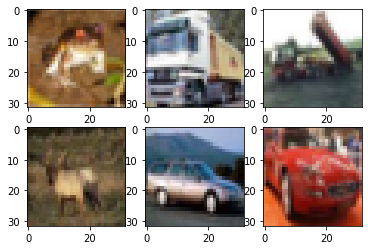

In [49]:
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(datapoints[i-1])

Exploring Data ranges:

In [60]:
datapoint = datapoints[0]
print(np.max((datapoint)))
print(np.min(datapoint))

255
0


Based on this data exploration process a good starting point for a transform involves:

- Mean Normalisation. 
- Casting numpy arrays to tensors.

Applying ToTensor Transform maps Python Image Library/Numpy Image Arrays (0-255 vals) to (0-1). Thus to normalise into the range [-1,1], subtract 0.5 and divide by 0.5. 

Note the order in which we give the transforms to transforms.Compose matters. We need to convert to Tensor first, then normalise. This is because normalise doesn't support PIL images. 

In [64]:
# For each of the n channels, we pass in the mean and stds as tuples:
# (mean[1], mean[2], mean[3],...,mean[n]) (std[1], std[2],...., std[3])
# In our case, we have 3 channels: RGB. 
transform = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Training and Modelling:

Initialising some hyperparameters:

In [67]:
batch_size = 5
epochs = 3
learning_rate = 0.001

Reloading the Data with transforms, and creating Dataloaders to allow each Batch Processing:

In [68]:
train_data = torchvision.datasets.CIFAR10(root='./',train=True, download=False, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./', train=False, download=False, transform=transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

##### Creating Neural Network:

The Neural Network will follow an architecture similar to the graphic:

[<img src="./Graphics/CNN-Architecture.png" width="500"/>](image.png)

CNN Architecture Described:

In [76]:
# Dealing with images (3x32x32): 3 Channels initially, setting first convolutional layer to have 6 channels.
channels_1 = 6
# Will apply a convolutional filter of 5x5. This will result in an image being transformed into a 6x28x28 tensor. 
filter_1 = 5
# Will apply a MaxPooling layer with a 2x2 matrix, with stride = 2. Note a Pooling layer doesn't have any model params. 
# Recall Maxpooling layers is applied to each channel seperately, thus outputting a 6x14x14 tensor.(Number of channels don't change).
max_pool_dim = 2
stride = 2 
# Applying another convolutional layer, outputting 16 channels using a 5x5 kernel. Results in a 16x10x10 tensor. 
channels_2 = 16
filter_2 = 5
# Will Applying Pooling layer again to output a 16x5x5 tensor. This will then be unstacked to 
# construct the first 1D layer in the CNN of 16*5*5 = 400 features.
unpacked_features_length = 400 
unpacked_layer_dim_1 = 100
unpacked_layer_dim_2 = 64
# Output layer has to be 10 as 10 Classes. 
output_layer = 10
# Will apply the ReLU activation function on each layer. 

Building the CNN Model:

In [77]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.multidimensional_layers = nn.Sequential(nn.Conv2d(3, channels_1, filter_1),
                                                nn.ReLU(), 
                                                nn.MaxPool2d(2,2),
                                                nn.Conv2d(channels_1, channels_2, filter_2),
                                                nn.ReLU(), 
                                                nn.MaxPool2d(2,2))

        self.unpacked_layers = nn.Sequential(nn.Linear(unpacked_features_length, unpacked_layer_dim_1), 
                                        nn.ReLU(),
                                        nn.Linear(unpacked_layer_dim_1, unpacked_layer_dim_2), 
                                        nn.ReLU(), 
                                        nn.Linear(unpacked_layer_dim_2, output_layer))

    def forward(self, x):
        feed_1 = self.multidimensional_layers(x)
        datapoint = torch.reshape(feed_1, (1, 400))
        feed_2 = self.unpacked_layers(datapoint)
        return feed_2 


In [78]:
model = CNN()

Initialise Optimiser and CrossEntropyLoss:

In [81]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

Explanation of what's happening under the hood for optimising: 

- Firstly, recall that PyTorch operates by building a Dynamic Computational Graph (DCG) and carries out computations upon running of code. 
- When we initialise our model, the "init" method is run, which initialises the layers/model params of our neural network. I believe that part of this step involves creating some tensor of model params and setting "requires_grad" to be true. This tells PyTorch that we will need the derivative of some function( in this case the loss) wrt to these variables. 
- Now the model params are setup, can start optimising. We pass one batch of our training data, into the model, which returns some predictions. (Predictions dependent upon the model params). 
- We can then compute the loss as we have predictions and the real labels. Note that the loss is dependent on the model params through the predictions. (CrossEntropyLoss applies the Softmax function for us).
- Running the command "loss.backward()", tells PyTorch, compute the derivative of the loss wrt the model params. Derivatives are computed using chain rule and numerical differentiation. 
- Then calling optimizer.step() will apply the optimisation method. Most, if not all optimisers required the gradient of the loss. 
- Calling optimizer.zero_grad() is used to set the gradient to 0, as if not, the gradient accumulates. 
- Repeating the above: is a way of reducing the loss function, and thus optimising our model.
- We do this for as many batches and epochs that we'd like.  